In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np 
import matplotlib.pyplot as plt
import cv2 
import matplotlib

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [253]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model_features.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_features.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model_features.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
# model_features.add(layers.Dense(16, activation='relu'))
# model_features.add(layers.Dense(7, activation='sigmoid'))

model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 10s 13ms/step - loss: 0.5103 - accuracy: 0.8391 - val_loss: 0.1731 - val_accuracy: 0.9509
Epoch 2/10
750/750 [==============================] - 9s 12ms/step - loss: 0.1316 - accuracy: 0.9641 - val_loss: 0.1053 - val_accuracy: 0.9720
Epoch 3/10
750/750 [==============================] - 9s 12ms/step - loss: 0.0920 - accuracy: 0.9742 - val_loss: 0.0775 - val_accuracy: 0.9796
Epoch 4/10
750/750 [==============================] - 9s 13ms/step - loss: 0.0688 - accuracy: 0.9802 - val_loss: 0.0778 - val_accuracy: 0.9786
Epoch 5/10
750/750 [==============================] - 9s 12ms/step - loss: 0.0547 - accuracy: 0.9842 - val_loss: 0.0678 - val_accuracy: 0.9818
Epoch 6/10
750/750 [==============================] - 9s 12ms/step - loss: 0.0446 - accuracy: 0.9867 - val_loss: 0.0635 - val_accuracy: 0.9828
Epoch 7/10
750/750 [==============================] - 9s 12ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.0700 - val_accuracy: 0.982

In [254]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

  1/313 [..............................] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

313/313 [==============================] - 2s 5ms/step - loss: 0.0546 - accuracy: 0.9841
Test accuracy: 0.9840999841690063


In [5]:
# Save the model
model.save('../models/mnist_cnn_model.h5')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 2)         20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 4)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 8)           296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 16)          1168      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0

In [7]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(preds.shape, last_conv_layer_output.shape)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            # print(pred_index)
        
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # print(grads.shape)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # print(heatmap.shape)
    heatmap = tf.squeeze(heatmap)
    # print(heatmap.shape)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    # jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    # print(jet_heatmap.shape)
    # jet_heatmap = im.fromarray(jet_heatmap) 
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[0], img.shape[1]))

    return jet_heatmap

In [8]:
model.layers[-7].name, model.layers[-5].name, model.layers[-3].name

('conv2d_1', 'conv2d_2', 'flatten')

Predicted: 0


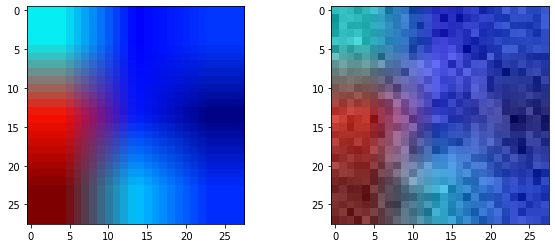

In [9]:
last_conv_layer_name = model.layers[-5].name

# img_array = get_img_array(test_image_folder_path+L[0], size=(image_height, image_width)) 
img_array = np.array([test_images[3]])

img_array[0] += np.random.normal(0, 0.5, test_images[0].shape)

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
# classification_model.layers[-1].activation = None

# Print what the top predicted class is

preds = model.predict(img_array)
pred_index = np.argmax(preds) 
# pred_index = 7
print("Predicted:", pred_index)


# # Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index)

jet_heatmap = save_and_display_gradcam(img_array[0], heatmap, cam_path="cam.jpg", alpha=0.4)
# print(heatmap)
# Display heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

axs[0].imshow(jet_heatmap)
# plt.show()

axs[1].imshow(img_array[0][:, :, 0], cmap='gray')
axs[1].imshow(jet_heatmap, alpha=0.6)
plt.show()

In [10]:
conv_layers = [model.layers[-8].name, model.layers[-6].name, model.layers[-4].name]


model_layers = models.Model(model.inputs, [model.get_layer(name).output for name in conv_layers]+[model.output])



outs = []

for i in range(1000) : 
    
    img_array = np.array([test_images[i]])
    out = model_layers(img_array)
    outs.append(out)
    # print(out[2][0].shape, out[3][0].shape)
    
    # print(activations[-1], labels[-1])
    # break

In [11]:
activations = []
labels = []

for i in range(1000) : 

    out = outs[i]
    # print(out[2].shape)
    activations.append(np.array(out[2][0][:, :, :]).flatten())
    labels.append(np.argmax(np.array(out[3][0])))

activations = np.array(activations)
labels = np.array(labels)

In [12]:
activations.shape

(1000, 16)

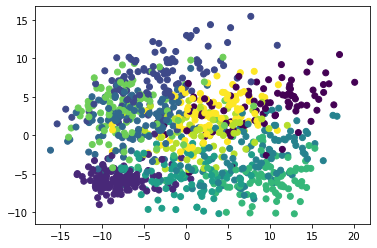

In [13]:
from sklearn.decomposition import PCA 


pca = PCA(n_components=16)
X_proj = pca.fit_transform(activations)

plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels)
plt.show()

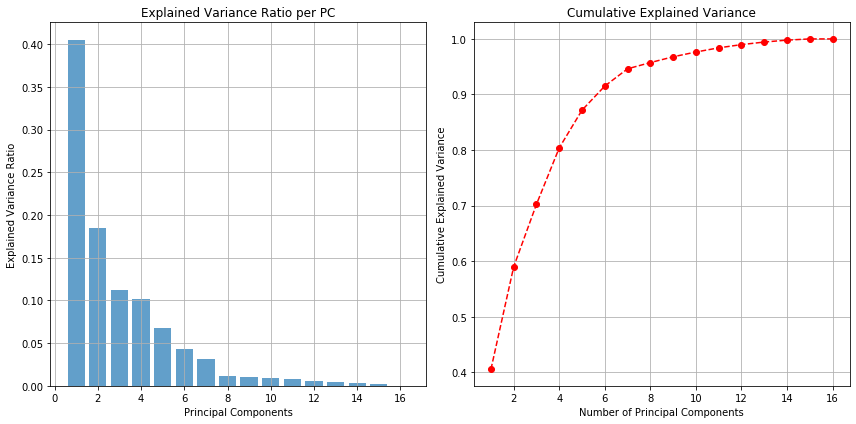

In [14]:
# Plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.title('Explained Variance Ratio per PC')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
embd_layer = model.layers[-3].name
embedding_model = models.Model(model.inputs, model.get_layer(embd_layer).output)

embedding = embedding_model(train_images)
embedding_test = embedding_model(test_images)

In [16]:
# embedding = np.array(embedding)
# embedding_flat = np.zeros((embedding.shape[0], embedding.shape[1]*embedding.shape[2]*embedding.shape[3]))

# for i in range(embedding.shape[0]) : 
#     embedding_flat[i] = embedding[i].flatten()
    
# embedding_test = np.array(embedding_test)
# embedding_flat_test = np.zeros((embedding_test.shape[0], embedding_test.shape[1]*embedding_test.shape[2]*embedding_test.shape[3]))

# for i in range(embedding_test.shape[0]) : 
#     embedding_flat_test[i] = embedding_test[i].flatten()

In [17]:
pca = PCA(n_components=10)
E_proj_train = pca.fit_transform(embedding)
E_proj_test = pca.transform(embedding_test)

In [18]:
train_labels_int = np.argmax(train_labels, axis=1)
test_labels_int = np.argmax(test_labels, axis=1)
train_labels_int.shape, test_labels_int.shape

((60000,), (10000,))

In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score


# scores = []
# neighbors = list(range(2, 50))

# for n in neighbors : 
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(E_proj_train, train_labels_int)

test_labels_pred = knn.predict(E_proj_test)
# scores.append(accuracy_score(test_labels_int, test_labels_pred))
# print(n)
# break

In [20]:
# plt.plot(neighbors, scores)
# plt.xlabel('n_neighbors')
# plt.ylabel('accuracy')
# plt.title('knn accurac ./. number of neighbors')
# plt.show()

In [21]:
from sklearn.metrics import accuracy_score

knn_acc = accuracy_score(test_labels_int, test_labels_pred)
f'knn accuracy: {knn_acc}', f'Test accuracy: {test_acc}'

('knn accuracy: 0.9629', 'Test accuracy: 0.9510999917984009')

<h3>New Idea (Feature map learning)</h3>

In [49]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [50]:
train_images.shape, train_labels.shape

((60000, 28, 28, 1), (60000, 10))

In [159]:
train_features, test_features = np.zeros((train_images.shape[0], 7)), np.zeros((test_images.shape[0], 7))

mapping = {0:[0, 1, 2, 3, 4, 5], 1:[1, 2], 2:[0, 1, 6, 4, 3], 3:[0, 1, 6, 2, 3], 4:[1, 5, 6, 2], 5:[0, 5, 6, 2, 3], 6:[5, 6, 2, 3, 4], 7:[0, 1, 2], 8:[0, 1, 2, 3, 4, 5, 6], 9:[0, 5, 6, 1, 2]}

for i in range(train_labels.shape[0]) : 
    num = np.argmax(train_labels[i])
    train_features[i][mapping[num]] = 1 
    
for i in range(test_labels.shape[0]) : 
    num = np.argmax(test_labels[i])
    test_features[i][mapping[num]] = 1 
    


In [168]:
# Build the CNN model_features
model_features = models.Sequential()
model_features.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_features.add(layers.MaxPooling2D((2, 2)))
model_features.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model_features.add(layers.MaxPooling2D((2, 2)))
model_features.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_features.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_features.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model_features.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_features.add(layers.Flatten())
# model_features.add(layers.Dense(16, activation='relu'))
model_features.add(layers.Dense(7, activation='sigmoid'))

# Compile the model_features
# model_features.compile(optimizer='adam', 
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model_features.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model_features
model_features.fit(train_images, train_features, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 9s 13ms/step - loss: 0.0869 - binary_accuracy: 0.9672 - val_loss: 0.0378 - val_binary_accuracy: 0.9872
Epoch 2/5
750/750 [==============================] - 9s 12ms/step - loss: 0.0308 - binary_accuracy: 0.9895 - val_loss: 0.0241 - val_binary_accuracy: 0.9922
Epoch 3/5
750/750 [==============================] - 9s 12ms/step - loss: 0.0218 - binary_accuracy: 0.9927 - val_loss: 0.0214 - val_binary_accuracy: 0.9932
Epoch 4/5
750/750 [==============================] - 9s 12ms/step - loss: 0.0166 - binary_accuracy: 0.9944 - val_loss: 0.0174 - val_binary_accuracy: 0.9946
Epoch 5/5
750/750 [==============================] - 9s 12ms/step - loss: 0.0134 - binary_accuracy: 0.9953 - val_loss: 0.0163 - val_binary_accuracy: 0.9946


In [169]:
test_loss, test_acc = model_features.evaluate(test_images, test_features)
print(f'Test accuracy: {test_acc}')

  1/313 [..............................] - ETA: 0s - loss: 0.0043 - binary_accuracy: 1.0000

313/313 [==============================] - 2s 5ms/step - loss: 0.0157 - binary_accuracy: 0.9949
Test accuracy: 0.9949281215667725


In [170]:
pred_features = model_features(test_images)
pred_features.shape

TensorShape([10000, 7])

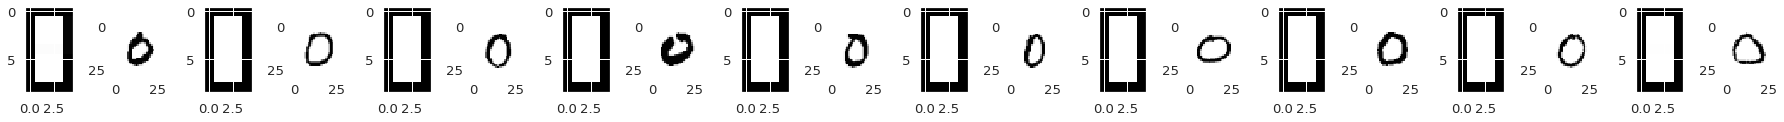

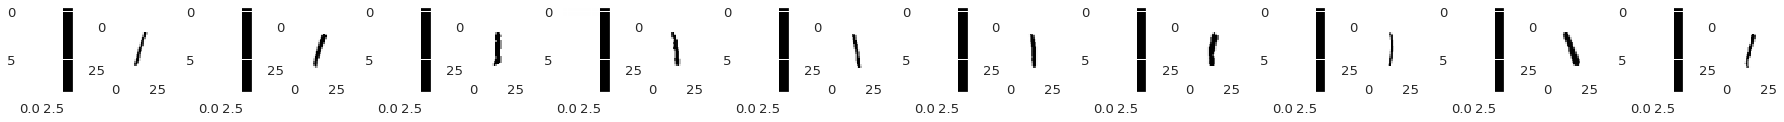

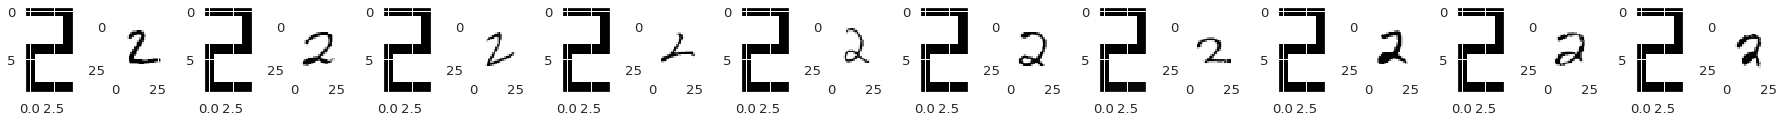

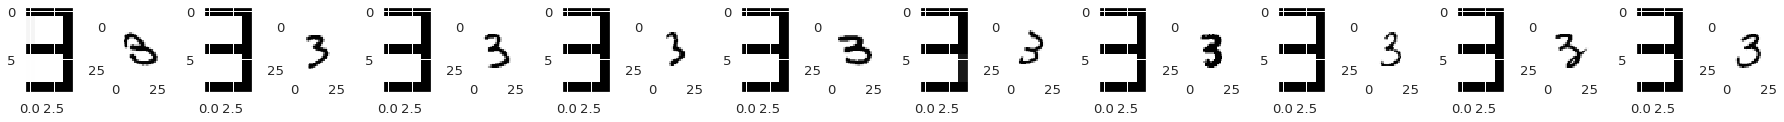

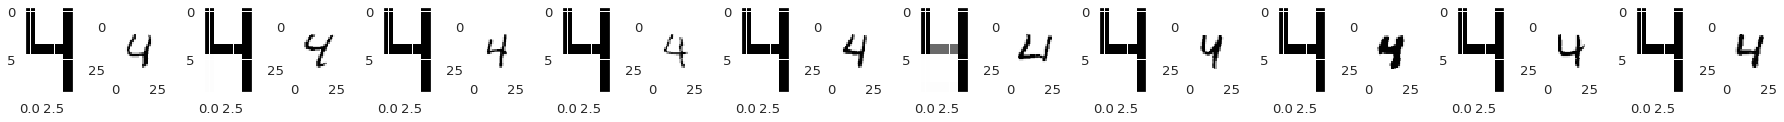

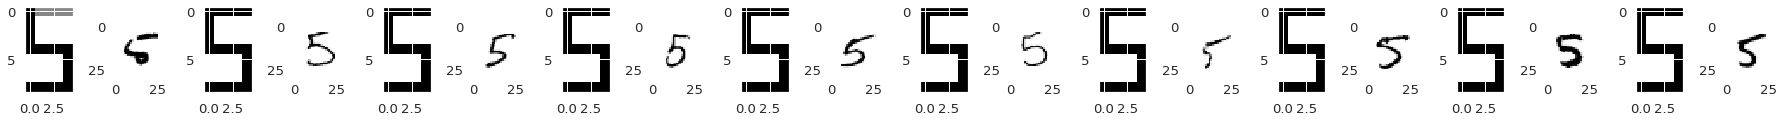

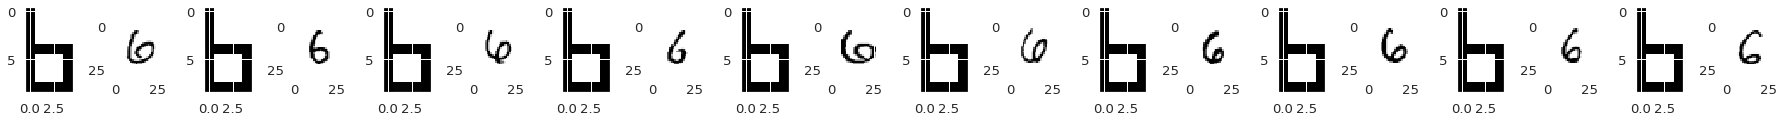

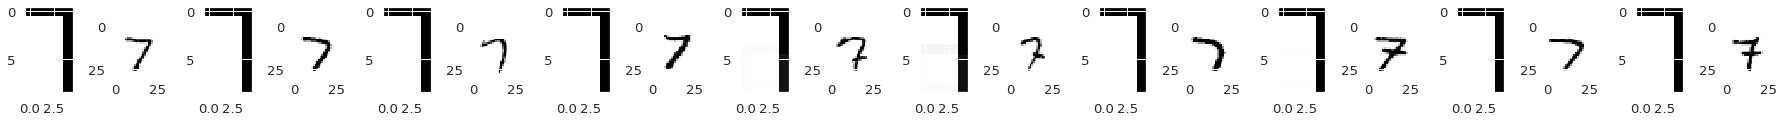

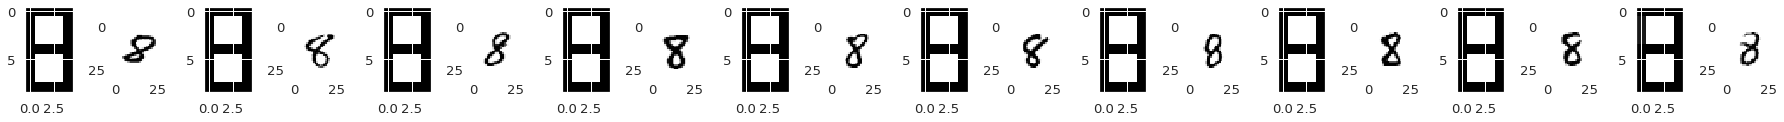

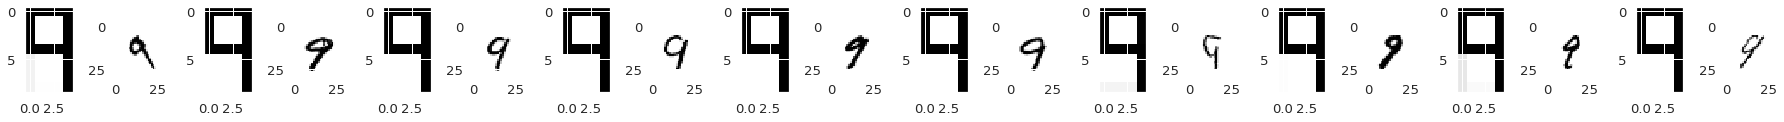

In [171]:
def color(mat, idx, value) : 
    
    if idx==0 : 
        mat[0, :] = value 
    if idx==1 : 
        mat[:5, -1] = value 
    if idx==2 : 
        mat[5:, -1] = value 
    if idx==3 : 
        mat[-1, :] = value 
    if idx==4 : 
        mat[5:, 0] = value 
    if idx==5 : 
        mat[:5, 0] = value 
    if idx==6 : 
        mat[4, :] = value 
        

def draw_digit(vector, label) : 
    
    mat = np.zeros((9, 5))
    
    args = np.argsort(vector)
    
    for i in args : 
        color(mat, i, vector[i])
        
    # plt.imshow(mat, cmap='Greys')
    # plt.title(f'True label : {label}')
    # plt.show()
    return mat
    
for i in range(10) : 
    # v = np.zeros(7)
    # v[mapping[i]] = 1 
    # print(i, mapping[i])
    
    plt.figure(figsize=(25, 10))  # Adjust the figure size as needed

    # Plot the first image
    
    args = (np.argmax(test_labels, axis=1)==i)
    predictions = pred_features[args][:10]
    images = test_images[args][:10]
    
    
    for k in range(10) :
        
        # print(predictions[k])
        mat = draw_digit(predictions[k], i)
        plt.subplot(1, 20, 2*k+1)
        plt.imshow(mat, cmap='Greys')
        plt.subplot(1, 20, 2*k+2)
        plt.imshow(images[k][:, :, 0], cmap='Greys')
        # plt.title('Image 1')
        # plt.axis('off')


    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()

In [172]:
model_complete = models.Sequential()
model_complete.add(model_features)  # Adding the layers from the pre-trained model

# Freeze the weights of the pre-trained layers
for layer in model_features.layers:
    layer.trainable = False

# model_features.layers[-1] = True
# model_features.layers[-2] = True

# Add a new fully connected layer for the final classification (10 classes)
model_complete.add(layers.Dense(10, activation='softmax'))

# Compile the model
model_complete.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model to check the architecture
# model_complete.summary()

model_complete.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 6s 8ms/step - loss: 1.7510 - accuracy: 0.5372 - val_loss: 1.2181 - val_accuracy: 0.8874
Epoch 2/5
750/750 [==============================] - 6s 8ms/step - loss: 0.9076 - accuracy: 0.9639 - val_loss: 0.6843 - val_accuracy: 0.9843
Epoch 3/5
750/750 [==============================] - 6s 8ms/step - loss: 0.5311 - accuracy: 0.9907 - val_loss: 0.4285 - val_accuracy: 0.9850
Epoch 4/5
750/750 [==============================] - 6s 8ms/step - loss: 0.3409 - accuracy: 0.9909 - val_loss: 0.2910 - val_accuracy: 0.9852
Epoch 5/5
750/750 [==============================] - 6s 8ms/step - loss: 0.2340 - accuracy: 0.9909 - val_loss: 0.2105 - val_accuracy: 0.9856


In [173]:
test_loss, test_acc = model_complete.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

 11/313 [>.............................] - ETA: 1s - loss: 0.1953 - accuracy: 0.9886

313/313 [==============================] - 2s 5ms/step - loss: 0.2064 - accuracy: 0.9881
Test accuracy: 0.988099992275238


In [174]:
# model_complete.layers[-2].name

In [196]:
# fine_tuned_model = models.Model(model_complete.inputs, [model_complete.get_layer(model_complete.layers[-2].name).output])

pred_features = model_features(test_images)
pred_features.shape

TensorShape([10000, 7])

In [176]:
# for i in range(10) : 
#     # v = np.zeros(7)
#     # v[mapping[i]] = 1 
#     # print(i, mapping[i])
    
#     plt.figure(figsize=(25, 10))  # Adjust the figure size as needed

#     # Plot the first image
    
#     args = (np.argmax(test_labels, axis=1)==i)
#     predictions = pred_features[args][:10]
#     images = test_images[args][:10]
    
    
#     for k in range(10) :
        
#         # print(predictions[k])
#         mat = draw_digit(predictions[k], i)
#         plt.subplot(1, 20, 2*k+1)
#         plt.imshow(mat, cmap='Greys')
#         plt.subplot(1, 20, 2*k+2)
#         plt.imshow(images[k][:, :, 0], cmap='Greys')
#         # plt.title('Image 1')
#         # plt.axis('off')


#     # Adjust layout to prevent clipping of titles
#     plt.tight_layout()

#     # Show the plot
#     plt.show()

In [209]:
last_conv_layer_name = model_features.layers[-3].name
last_conv_layer_name

'conv2d_63'

conv2d_63


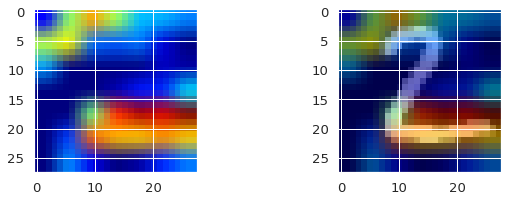

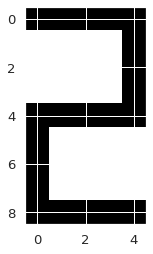

In [248]:
last_conv_layer_name = model_features.layers[-3].name
print(last_conv_layer_name)


id = 1
# img_array = get_img_array(test_image_folder_path+L[0], size=(image_height, image_width)) 
img_array = np.array([test_images[id]])

# img_array[0] += np.random.normal(0, 0.5, test_images[0].shape)

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
# classification_model.layers[-1].activation = None

# Print what the top predicted class is

def assemble_grads(img_array, idx=None): 
    
    jet_heatmap = np.zeros((28, 28, 3))
    preds = model_features.predict(img_array)
    for i in range(len(preds[0])) :
        # print(preds[0]) 
        if idx : 
            i = idx
        pred_index = i
        heatmap = make_gradcam_heatmap(img_array, model_features, last_conv_layer_name, pred_index=pred_index)
        j = save_and_display_gradcam(img_array[0], heatmap, cam_path="cam.jpg", alpha=0.4)
        # print(j.shape)
        jet_heatmap += j*preds[0, i]
    return jet_heatmap


# pred_index = np.argmax(preds) 
# # pred_index = 4
# print("Predicted:", pred_index)


# # Generate class activation heatmap



# print(heatmap)
# Display heatmap
jet_heatmap  = assemble_grads(img_array, 3)
if np.max(jet_heatmap) : 
    jet_heatmap /= np.max(jet_heatmap)

# print(pred_features[id])

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 

axs[0].imshow(jet_heatmap)
# plt.show()

axs[1].imshow(img_array[0][:, :, 0], cmap='gray')
axs[1].imshow(jet_heatmap, alpha=0.6)
plt.show()

mat = draw_digit(pred_features[id], 0)
plt.imshow(mat, cmap='Greys')
plt.show()

In [249]:
# last_conv_layer_name = model.layers[-7].name
# print(last_conv_layer_name)

# # img_array = get_img_array(test_image_folder_path+L[0], size=(image_height, image_width)) 
# img_array = np.array([test_images[id]])

# # img_array[0] += np.random.normal(0, 0.5, test_images[0].shape)

# # Make model
# # model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# # classification_model.layers[-1].activation = None

# # Print what the top predicted class is

# preds = model.predict(img_array)
# pred_index = np.argmax(preds) 
# # pred_index = 7
# print("Predicted:", pred_index)


# # # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index)

# jet_heatmap = save_and_display_gradcam(img_array[0], heatmap, cam_path="cam.jpg", alpha=0.4)
# # print(heatmap)
# # Display heatmap

# fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

# axs[0].imshow(jet_heatmap)
# # plt.show()

# axs[1].imshow(img_array[0][:, :, 0], cmap='gray')
# axs[1].imshow(jet_heatmap, alpha=0.6)
# plt.show()

In [251]:
pred_labels1 = model_complete(test_images)
P1 = np.argmax(pred_labels1, axis=1)

pred_labels2 = model(test_images)
P2 = np.argmax(pred_labels2, axis=1)
T = np.argmax(test_labels, axis=1)

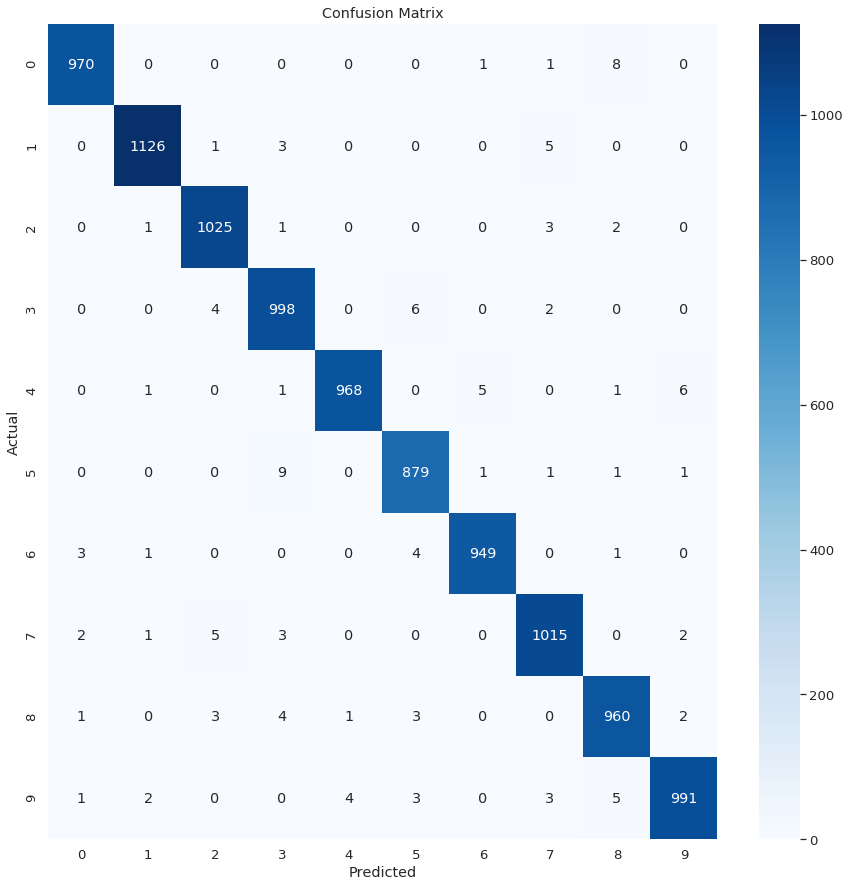

In [252]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

conf_matrix = confusion_matrix(T, P1)


# Display the confusion matrix using Seaborn
labels = [str(i) for i in range(10)]
sns.set(font_scale=1.2)  # Adjust the font size for better readability
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:


# features = model_features(test_images)

# # accuracy_score(T, P)
# args = np.where(P1!=T)[0]
# for i in args[:19] :
#     print('Ground Truth : ', T[i])
#     print('Model 1 prediction : ', P2[i])
#     print('Model 2 prediction : ', P1[i]) 
    
#     fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
#     axs[0].imshow(test_images[i][:, :, 0], cmap='Greys')
#     # plt.show()

#     mat = draw_digit(features[i], P1[i])
#     axs[1].imshow(mat, cmap='Greys')
#     # axs[1].imshow(jet_heatmap, alpha=0.6)
#     plt.show()
#     # print(features[i])
#     # break